# Importing Libs

In [1]:
# Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from collections import Counter
import string
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('/content/ling-spam-dataset-EAS-PAP(Sheet1).csv')
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


# Data Cleaning

In [3]:
# checing null values
df.isnull().sum()

,0
subject,62
message,0
label,0


In [4]:
df.fillna(df['subject'].mode().values[0],inplace=True)

In [5]:
# checing null values
df.isnull().sum()

,0
subject,0
message,0
label,0


In [6]:
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


# Preprocessing Email Messages

In [7]:
df['sub_mssg']=df['subject']+df['message']
df['length']=df['sub_mssg'].apply(len)

df.head()

,subject,message,label,sub_mssg,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...,2895
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j...",1816
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1485
3,risk,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328
4,request book information,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070


In [8]:
# drop un-necessary features
df.drop('subject',axis=1,inplace=True)

# check it once
df.head()

,message,label,sub_mssg,length
0,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...,2895
1,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j...",1816
2,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...,1485
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070


In [9]:
import re

def decontact(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
mssg=decontact(df['message'][70])
mssg

'hi , i am new to the list . and since english is not my first language , i apologize for the mistakes you might find below : - ) . i hope that you will not mind if some of my explanations are in french . for my ph . d . semiotics , i am writing a dissertation on discourse and science-fiction and i need some information about the construction of neologisms in french and in english . ( neologisms are useful in sf , specially in the scientific field ! ) in french , neologisms are made in 5 different ways ( i hope these are the right english words ) : derivation ; composition ; imitation ; pure invention ; amalgam . one might also add borrowings from other languages . here are some examples ( sorry , the explanations are in french ) : - derivation : mot derive : " position " peut produire le verbe " positionner " ; - composition : mot compose : si " monotone " est decompose ( " mono " / " tone " ) , on peut recomposer " polytone " ; a partir de " telephone " on peut produire en science-fi

In [11]:
#REPLACING NUMBERS
df['sub_mssg'] = df['sub_mssg'].str.replace(r'\d+(\.\d+)?', 'numbers', regex=True)

# CONVERTING EVERYTHING TO LOWERCASE
df['sub_mssg'] = df['sub_mssg'].str.lower()

# REPLACING NEXT LINES BY 'WHITE SPACE'
df['sub_mssg'] = df['sub_mssg'].str.replace(r'\n', " ", regex=True)

# REPLACING EMAIL IDs BY 'MAILID'
df['sub_mssg'] = df['sub_mssg'].str.replace(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', 'MailID', regex=True)

# REPLACING URLs BY 'Links'
df['sub_mssg'] = df['sub_mssg'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'Links', regex=True)

# REPLACING CURRENCY SIGNS BY 'MONEY'
df['sub_mssg'] = df['sub_mssg'].str.replace(r'£|\$', 'Money', regex=True)

# REPLACING LARGE WHITE SPACE BY SINGLE WHITE SPACE
df['sub_mssg'] = df['sub_mssg'].str.replace(r'\s+', ' ', regex=True)

# REPLACING LEADING AND TRAILING WHITE SPACE BY SINGLE WHITE SPACE
df['sub_mssg'] = df['sub_mssg'].str.replace(r'^\s+|\s+?$', '', regex=True)

# REPLACING CONTACT NUMBERS
df['sub_mssg'] = df['sub_mssg'].str.replace(r'\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}', 'contact number', regex=True)

# REPLACING SPECIAL CHARACTERS BY WHITE SPACE
df['sub_mssg'] = df['sub_mssg'].str.replace(r'[^a-zA-Z0-9\s]+', ' ', regex=True)

# Remove any remaining extra spaces after cleaning
df['sub_mssg'] = df['sub_mssg'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [12]:
df['sub_mssg'][0]

'job posting apple iss research centercontent length numbers apple iss research center a us Money numbers million joint venture between apple computer inc and the institute of systems science of the national university of singapore located in singapore is looking for a senior speech scientist the successful candidate will have research expertise in computational linguistics including natural language processing and english and chinese statistical language modeling knowledge of state of the art corpus based n gram language models cache language models and part of speech language models are required a text to speech project leader the successful candidate will have research expertise expertise in two or more of the following areas computational linguistics including natural language parsing lexical database design and statistical language modeling text tokenization and normalization prosodic analysis substantial knowledge of the phonology syntax and semantics of chinese is required knowl

In [13]:
!pip install nltk
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download the stopwords data
nltk.download('stopwords')

# removing stopwords
stop = stopwords.words('english')
df['Cleaned_Text'] = df['sub_mssg'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# stemming and lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fungsi untuk stemming dan lemmatization
def apply_stemming_lemmatization(text):
    tokens = text.split()
    stemmed = [stemmer.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]
    return ' '.join(lemmatized)

# Terapkan ke kolom Cleaned_Text
df['Cleaned_Text'] = df['Cleaned_Text'].apply(apply_stemming_lemmatization)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,message,label,sub_mssg,length,Cleaned_Text
0,content - length : 3386 apple-iss research cen...,0,job posting apple iss research centercontent l...,2895,job post appl iss research centercont length n...
1,"lang classification grimes , joseph e . and ba...",0,sociolinguisticslang classification grimes jos...,1816,sociolinguisticslang classif grime joseph e ba...
2,i am posting this inquiry for sergei atamas ( ...,0,query letter frequencies for text identificati...,1485,queri letter frequenc text identificationi pos...
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...,328,riska colleagu research differ degre risk perc...
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...,1070,request book informationearli morn phone frien...


In [14]:
df.drop('message',axis=1,inplace=True)

df.drop('sub_mssg',axis=1,inplace=True)

df.head()

,label,length,Cleaned_Text
0,0,2895,job post appl iss research centercont length n...
1,0,1816,sociolinguisticslang classif grime joseph e ba...
2,0,1485,queri letter frequenc text identificationi pos...
3,0,328,riska colleagu research differ degre risk perc...
4,0,1070,request book informationearli morn phone frien...


In [15]:
df.isnull().sum()

,0
label,0
length,0
Cleaned_Text,0


In [16]:
df['lgth_clean']=df['Cleaned_Text'].apply(len)
df.head()

,label,length,Cleaned_Text,lgth_clean
0,0,2895,job post appl iss research centercont length n...,1727
1,0,1816,sociolinguisticslang classif grime joseph e ba...,1321
2,0,1485,queri letter frequenc text identificationi pos...,1018
3,0,328,riska colleagu research differ degre risk perc...,189
4,0,1070,request book informationearli morn phone frien...,583


In [17]:
original_length=sum(df['length'])
after_cleaning=sum(df['lgth_clean'])

print("original_length",original_length)
print('after_cleaning',after_cleaning)

original_length 9437398
after_cleaning 5934691


# Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count Vectorizer
count_vectorizer = CountVectorizer()
count_features = count_vectorizer.fit_transform(df['Cleaned_Text'])

# Convert the matrix to a DataFrame for better readability (optional)
count_features_df = pd.DataFrame(
    count_features.toarray(),
    columns=count_vectorizer.get_feature_names_out()
)

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(df['Cleaned_Text'])

# Convert the matrix to a DataFrame for better readability (optional)
tfidf_features_df = pd.DataFrame(
    tfidf_features.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out()
)

# Hyperparameter Tuning

## KNN

### Count Vactorization

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split data
X = count_features
y = df['label']  # Target variable
X_train_countknn, X_test_countknn, y_train_countknn, y_test_countknn = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manual Search

In [20]:
# KNN
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn.fit(X_train_countknn, y_train_countknn)
y_pred_knn = knn.predict(X_test_countknn)
print("KNN Accuracy (Manual):", accuracy_score(y_test_countknn, y_pred_knn))
print("KNN Precision (Manual):", precision_score(y_test_countknn, y_pred_knn, average='weighted'))
print("KNN Recall (Manual):", recall_score(y_test_countknn, y_pred_knn, average='weighted'))
print("KNN F1-Score (Manual):", f1_score(y_test_countknn, y_pred_knn, average='weighted'))

KNN Accuracy (Manual): 0.917098445595855
KNN Precision (Manual): 0.9219955996483289
KNN Recall (Manual): 0.917098445595855
KNN F1-Score (Manual): 0.9188418554415855


#### Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV
# KNN
knn_params = {'n_neighbors': [2, 3, 4, 5], 'metric': ['euclidean', 'manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='accuracy')
knn_grid.fit(X_train_countknn, y_train_countknn)

y_pred_grid = knn_grid.predict(X_test_countknn)
print("Grid Search - Best Params:", knn_grid.best_params_)
print("KNN Accuracy (Grid Search):", knn_grid.best_score_)
print("Grid Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countknn, y_pred_grid, output_dict=True)).transpose())

Grid Search - Best Params: {'metric': 'euclidean', 'n_neighbors': 2}
KNN Accuracy (Grid Search): 0.9217791307970941
Grid Search - Classification Report:
              precision    recall  f1-score     support
0              0.962719  0.946121  0.954348  464.000000
1              0.796748  0.852174  0.823529  115.000000
accuracy       0.927461  0.927461  0.927461    0.927461
macro avg      0.879734  0.899147  0.888939  579.000000
weighted avg   0.929754  0.927461  0.928365  579.000000


#### Random Search

In [63]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# KNN
knn_random = RandomizedSearchCV(KNeighborsClassifier(), knn_params, n_iter=5, cv=3, random_state=42, scoring='accuracy')
knn_random.fit(X_train_countknn, y_train_countknn)

y_pred_random = knn_random.predict(X_test_countknn)
print("Random Search - Best Params:", knn_random.best_params_)
print("KNN Accuracy (Random Search):", knn_random.best_score_)
print("Random Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countknn, y_pred_random, output_dict=True)).transpose())

Random Search - Best Params: {'n_neighbors': 2, 'metric': 'euclidean'}
KNN Accuracy (Random Search): 0.9217791307970941
Random Search - Classification Report:
              precision    recall  f1-score     support
0              0.962719  0.946121  0.954348  464.000000
1              0.796748  0.852174  0.823529  115.000000
accuracy       0.927461  0.927461  0.927461    0.927461
macro avg      0.879734  0.899147  0.888939  579.000000
weighted avg   0.929754  0.927461  0.928365  579.000000


#### Genetic Algorithm (TPOT)

In [23]:
!pip install tpot
from tpot import TPOTClassifier

In [24]:
# TPOT for KNN
tpot_knn = TPOTClassifier(generations=5, population_size=20, cv=3, random_state=42, verbosity=2, config_dict={
    'sklearn.neighbors.KNeighborsClassifier': knn_params
})
tpot_knn.fit(X_train_countknn, y_train_countknn)

y_pred_tpot = tpot_knn.predict(X_test_countknn)
print("TPOT - Best Pipeline:", tpot_knn.fitted_pipeline_)
print("TPOT - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countknn, y_pred_tpot, output_dict=True)).transpose())

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9217791307970941

Generation 2 - Current best internal CV score: 0.9217791307970941

Generation 3 - Current best internal CV score: 0.9217791307970941

Generation 4 - Current best internal CV score: 0.9217791307970941

Generation 5 - Current best internal CV score: 0.9217791307970941

Best pipeline: KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), metric=euclidean, n_neighbors=2)
TPOT - Best Pipeline: Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7f8598f91990>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7f8598f91990>))])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=2))])
TPOT - Cla

### TF-IDF Vactorization

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split data
X = tfidf_features  # Replace with tfidf_features if using TF-IDF
y = df['label']  # Target variable
X_train_tfidfknn, X_test_tfidfknn, y_train_tfidfknn, y_test_tfidfknn = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manual Search

In [26]:
# KNN
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn.fit(X_train_tfidfknn, y_train_tfidfknn)
y_pred_knn = knn.predict(X_test_tfidfknn)
print("KNN Accuracy (Manual):", accuracy_score(y_test_tfidfknn, y_pred_knn))
print("KNN Precision (Manual):", precision_score(y_test_tfidfknn, y_pred_knn, average='weighted'))
print("KNN Recall (Manual):", recall_score(y_test_tfidfknn, y_pred_knn, average='weighted'))
print("KNN F1-Score (Manual):", f1_score(y_test_tfidfknn, y_pred_knn, average='weighted'))

KNN Accuracy (Manual): 0.9810017271157168
KNN Precision (Manual): 0.9809482617904726
KNN Recall (Manual): 0.9810017271157168
KNN F1-Score (Manual): 0.9809704712905138


#### Grid Search

In [27]:
from sklearn.model_selection import GridSearchCV
# KNN
knn_params = {'n_neighbors': [2, 3, 4, 5], 'metric': ['euclidean', 'manhattan']}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, scoring='accuracy')
knn_grid.fit(X_train_tfidfknn, y_train_tfidfknn)

y_pred_grid = knn_grid.predict(X_test_tfidfknn)
print("Grid Search - Best Params:", knn_grid.best_params_)
print("KNN Accuracy (Grid Search):", knn_grid.best_score_)
print("Grid Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfknn, y_pred_grid, output_dict=True)).transpose())

Grid Search - Best Params: {'metric': 'euclidean', 'n_neighbors': 2}
KNN Accuracy (Grid Search): 0.9719097285224985
Grid Search - Classification Report:
              precision    recall  f1-score    support
0              0.982833  0.987069  0.984946  464.00000
1              0.946903  0.930435  0.938596  115.00000
accuracy       0.975820  0.975820  0.975820    0.97582
macro avg      0.964868  0.958752  0.961771  579.00000
weighted avg   0.975696  0.975820  0.975740  579.00000


#### Random Search

In [28]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# KNN
knn_random = RandomizedSearchCV(KNeighborsClassifier(), knn_params, n_iter=5, cv=3, random_state=42, scoring='accuracy')
knn_random.fit(X_train_tfidfknn, y_train_tfidfknn)

y_pred_random = knn_random.predict(X_test_tfidfknn)
print("Random Search - Best Params:", knn_random.best_params_)
print("KNN Accuracy (Random Search):", knn_random.best_score_)
print("Random Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfknn, y_pred_random, output_dict=True)).transpose())

Random Search - Best Params: {'n_neighbors': 2, 'metric': 'euclidean'}
KNN Accuracy (Random Search): 0.9719097285224985
Random Search - Classification Report:
              precision    recall  f1-score    support
0              0.982833  0.987069  0.984946  464.00000
1              0.946903  0.930435  0.938596  115.00000
accuracy       0.975820  0.975820  0.975820    0.97582
macro avg      0.964868  0.958752  0.961771  579.00000
weighted avg   0.975696  0.975820  0.975740  579.00000


#### Genetic Algorithm (TPOT)

In [29]:
!pip install tpot
from tpot import TPOTClassifier

In [30]:
# TPOT for KNN
tpot_knn = TPOTClassifier(generations=5, population_size=20, cv=3, random_state=42, verbosity=2, config_dict={
    'sklearn.neighbors.KNeighborsClassifier': knn_params
})
tpot_knn.fit(X_train_tfidfknn, y_train_tfidfknn)

y_pred_tpot = tpot_knn.predict(X_test_tfidfknn)
print("TPOT - Best Pipeline:", tpot_knn.fitted_pipeline_)
print("TPOT - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfknn, y_pred_tpot, output_dict=True)).transpose())

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9719097285224985

Generation 2 - Current best internal CV score: 0.9719097285224985

Generation 3 - Current best internal CV score: 0.9719097285224985

Generation 4 - Current best internal CV score: 0.9719097285224985

Generation 5 - Current best internal CV score: 0.9719097285224985

Best pipeline: KNeighborsClassifier(CombineDFs(input_matrix, input_matrix), metric=euclidean, n_neighbors=2)
TPOT - Best Pipeline: Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7f8598f91990>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7f8598f91990>))])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=2))])
TPOT - Cla

## Ada Boost Classifier

### Count Vactorization

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split data
X = count_features
y = df['label']  # Target variable
X_train_countab, X_test_countab, y_train_countab, y_test_countab = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manual Search

In [32]:
# AdaBoost
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
adaboost.fit(X_train_countab, y_train_countab)
y_pred_ada = adaboost.predict(X_test_countab)
print("AdaBoost Accuracy (Manual):", accuracy_score(y_test_countab, y_pred_ada))
print("AdaBoost Precision (Manual):", precision_score(y_test_countab, y_pred_ada, average='weighted'))
print("AdaBoost Recall (Manual):", recall_score(y_test_countab, y_pred_ada, average='weighted'))
print("AdaBoost F1-Score (Manual):", f1_score(y_test_countab, y_pred_ada, average='weighted'))

AdaBoost Accuracy (Manual): 0.9844559585492227
AdaBoost Precision (Manual): 0.9845493629554662
AdaBoost Recall (Manual): 0.9844559585492227
AdaBoost F1-Score (Manual): 0.9842701800245095


#### Grid Search

In [33]:
from sklearn.model_selection import GridSearchCV
# AdaBoost
adaboost_params = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}
adaboost_grid = GridSearchCV(AdaBoostClassifier(), adaboost_params, cv=3, scoring='accuracy')
adaboost_grid.fit(X_train_countab, y_train_countab)

y_pred_grid = adaboost_grid.predict(X_test_countab)
print("Grid Search - Best Params:", adaboost_grid.best_params_)
print("AdaBoost Accuracy (Grid Search):", adaboost_grid.best_score_)
print("Grid Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countab, y_pred_grid, output_dict=True)).transpose())

Grid Search - Best Params: {'learning_rate': 1, 'n_estimators': 100}
AdaBoost Accuracy (Grid Search): 0.9904919031650348
Grid Search - Classification Report:
              precision    recall  f1-score     support
0              0.995690  0.995690  0.995690  464.000000
1              0.982609  0.982609  0.982609  115.000000
accuracy       0.993092  0.993092  0.993092    0.993092
macro avg      0.989149  0.989149  0.989149  579.000000
weighted avg   0.993092  0.993092  0.993092  579.000000


#### Random Search

In [34]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# AdaBoost
adaboost_random = RandomizedSearchCV(AdaBoostClassifier(), adaboost_params, n_iter=5, cv=3, random_state=42, scoring='accuracy')
adaboost_random.fit(X_train_countab, y_train_countab)

y_pred_random = adaboost_random.predict(X_test_countab)
print("Random Search - Best Params:", adaboost_random.best_params_)
print("AdaBoost Accuracy (Random Search):", adaboost_random.best_score_)
print("Random Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countab, y_pred_random, output_dict=True)).transpose())

Random Search - Best Params: {'n_estimators': 100, 'learning_rate': 1}
AdaBoost Accuracy (Random Search): 0.9904919031650348
Random Search - Classification Report:
              precision    recall  f1-score     support
0              0.995690  0.995690  0.995690  464.000000
1              0.982609  0.982609  0.982609  115.000000
accuracy       0.993092  0.993092  0.993092    0.993092
macro avg      0.989149  0.989149  0.989149  579.000000
weighted avg   0.993092  0.993092  0.993092  579.000000


#### Genetic Algorithm (TPOT)

In [35]:
!pip install tpot
from tpot import TPOTClassifier

In [36]:
# TPOT for AdaBoost
tpot_ada = TPOTClassifier(generations=2, population_size=20, cv=3, random_state=42, verbosity=2, config_dict="TPOT sparse")
tpot_ada.fit(X_train_countab, y_train_countab)

y_pred_tpot = tpot_ada.predict(X_test_countab)
print("TPOT - Best Pipeline:", tpot_ada.fitted_pipeline_)
print("TPOT - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countab, y_pred_tpot, output_dict=True)).transpose())

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.993952294868607

Generation 2 - Current best internal CV score: 0.993952294868607

Best pipeline: MultinomialNB(input_matrix, alpha=0.001, fit_prior=False)
TPOT - Best Pipeline: Pipeline(steps=[('multinomialnb', MultinomialNB(alpha=0.001, fit_prior=False))])
TPOT - Classification Report:
              precision    recall  f1-score    support
0              0.993521  0.991379  0.992449  464.00000
1              0.965517  0.973913  0.969697  115.00000
accuracy       0.987910  0.987910  0.987910    0.98791
macro avg      0.979519  0.982646  0.981073  579.00000
weighted avg   0.987959  0.987910  0.987930  579.00000


### TF-IDF Vactorization

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split data
X = tfidf_features
y = df['label']  # Target variable
X_train_tfidfab, X_test_tfidfab, y_train_tfidfab, y_test_tfidfab = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manual Search

In [38]:
# AdaBoost
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
adaboost.fit(X_train_tfidfab, y_train_tfidfab)
y_pred_ada = adaboost.predict(X_test_tfidfab)
print("AdaBoost Accuracy (Manual):", accuracy_score(y_test_tfidfab, y_pred_ada))
print("AdaBoost Precision (Manual):", precision_score(y_test_tfidfab, y_pred_ada, average='weighted'))
print("AdaBoost Recall (Manual):", recall_score(y_test_tfidfab, y_pred_ada, average='weighted'))
print("AdaBoost F1-Score (Manual):", f1_score(y_test_tfidfab, y_pred_ada, average='weighted'))

AdaBoost Accuracy (Manual): 0.9861830742659758
AdaBoost Precision (Manual): 0.9861471674943179
AdaBoost Recall (Manual): 0.9861830742659758
AdaBoost F1-Score (Manual): 0.986090450642137


#### Grid Search

In [39]:
from sklearn.model_selection import GridSearchCV
# AdaBoost
adaboost_params = {'n_estimators': [50, 100, 150], 'learning_rate': [0.01, 0.1, 1]}
adaboost_grid = GridSearchCV(AdaBoostClassifier(), adaboost_params, cv=3, scoring='accuracy')
adaboost_grid.fit(X_train_tfidfab, y_train_tfidfab)

y_pred_grid = adaboost_grid.predict(X_test_tfidfab)
print("Grid Search - Best Params:", adaboost_grid.best_params_)
print("AdaBoost Accuracy (Grid Search):", adaboost_grid.best_score_)
print("Grid Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfab, y_pred_grid, output_dict=True)).transpose())

Grid Search - Best Params: {'learning_rate': 0.1, 'n_estimators': 150}
AdaBoost Accuracy (Grid Search): 0.9883307684208876
Grid Search - Classification Report:
              precision    recall  f1-score     support
0              0.989316  0.997845  0.993562  464.000000
1              0.990991  0.956522  0.973451  115.000000
accuracy       0.989637  0.989637  0.989637    0.989637
macro avg      0.990154  0.977183  0.983507  579.000000
weighted avg   0.989649  0.989637  0.989568  579.000000


#### Random Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# AdaBoost
adaboost_random = RandomizedSearchCV(AdaBoostClassifier(), adaboost_params, n_iter=5, cv=3, random_state=42, scoring='accuracy')
adaboost_random.fit(X_train_tfidfab, y_train_tfidfab)

y_pred_random = adaboost_random.predict(X_test_tfidfab)
print("Random Search - Best Params:", adaboost_random.best_params_)
print("AdaBoost Accuracy (Random Search):", adaboost_random.best_score_)
print("Random Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfab, y_pred_random, output_dict=True)).transpose())

Random Search - Best Params: {'n_estimators': 150, 'learning_rate': 0.1}
AdaBoost Accuracy (Random Search): 0.9883307684208876
Random Search - Classification Report:
              precision    recall  f1-score     support
0              0.989316  0.997845  0.993562  464.000000
1              0.990991  0.956522  0.973451  115.000000
accuracy       0.989637  0.989637  0.989637    0.989637
macro avg      0.990154  0.977183  0.983507  579.000000
weighted avg   0.989649  0.989637  0.989568  579.000000


#### Genetic Algorithm (TPOT)

In [41]:
!pip install tpot
from tpot import TPOTClassifier

In [42]:
# TPOT for AdaBoost
tpot_ada = TPOTClassifier(generations=2, population_size=20, cv=3, random_state=42, verbosity=2, config_dict="TPOT sparse")
tpot_ada.fit(X_train_tfidfab, y_train_tfidfab)

y_pred_tpot = tpot_ada.predict(X_test_tfidfab)
print("TPOT - Best Pipeline:", tpot_ada.fitted_pipeline_)
print("TPOT - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfab, y_pred_tpot, output_dict=True)).transpose())

Optimization Progress:   0%|          | 0/60 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9952470716316203

Generation 2 - Current best internal CV score: 0.9952470716316203

Best pipeline: MultinomialNB(SelectPercentile(input_matrix, percentile=47), alpha=0.001, fit_prior=False)
TPOT - Best Pipeline: Pipeline(steps=[('selectpercentile', SelectPercentile(percentile=47)),
                ('multinomialnb', MultinomialNB(alpha=0.001, fit_prior=False))])
TPOT - Classification Report:
              precision    recall  f1-score    support
0              0.993521  0.991379  0.992449  464.00000
1              0.965517  0.973913  0.969697  115.00000
accuracy       0.987910  0.987910  0.987910    0.98791
macro avg      0.979519  0.982646  0.981073  579.00000
weighted avg   0.987959  0.987910  0.987930  579.00000


## Decision Tree

### **Count Vactorization**

In [43]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split data
X = count_features
y = df['label']  # Target variable
X_train_countdt, X_test_countdt, y_train_countdt, y_test_countdt = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manual Search

In [44]:
# Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=10, criterion='gini')
decision_tree.fit(X_train_countdt, y_train_countdt)
y_pred_tree = decision_tree.predict(X_test_countdt)
print("Decision Tree Accuracy (Manual):", accuracy_score(y_test_countdt, y_pred_tree))
print("Decision Tree Precision (Manual):", precision_score(y_test_countdt, y_pred_tree, average='weighted'))
print("Decision Tree Recall (Manual):", recall_score(y_test_countdt, y_pred_tree, average='weighted'))
print("Decision Tree F1-Score (Manual):", f1_score(y_test_countdt, y_pred_tree, average='weighted'))

Decision Tree Accuracy (Manual): 0.9689119170984456
Decision Tree Precision (Manual): 0.9689119170984456
Decision Tree Recall (Manual): 0.9689119170984456
Decision Tree F1-Score (Manual): 0.9689119170984456


#### Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV
# Decision Tree
tree_params = {'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy']}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3, scoring='accuracy')
tree_grid.fit(X_train_countdt, y_train_countdt)

y_pred_grid = tree_grid.predict(X_test_countdt)
print("Grid Search - Best Params:", tree_grid.best_params_)
print("Decision Tree Accuracy (Grid Search):", tree_grid.best_score_)
print("Grid Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countdt, y_pred_grid, output_dict=True)).transpose())

Grid Search - Best Params: {'criterion': 'entropy', 'max_depth': 10}
Decision Tree Accuracy (Grid Search): 0.9701803727075395
Grid Search - Classification Report:
              precision    recall  f1-score    support
0              0.989130  0.980603  0.984848  464.00000
1              0.924370  0.956522  0.940171  115.00000
accuracy       0.975820  0.975820  0.975820    0.97582
macro avg      0.956750  0.968563  0.962510  579.00000
weighted avg   0.976268  0.975820  0.975975  579.00000


#### Random Search

In [46]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Decision Tree
tree_random = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, n_iter=5, cv=3, random_state=42, scoring='accuracy')
tree_random.fit(X_train_countdt, y_train_countdt)

y_pred_random = tree_random.predict(X_test_countdt)
print("Random Search - Best Params:", tree_random.best_params_)
print("Decision Tree Accuracy (Random Search):", tree_random.best_score_)
print("Random Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countdt, y_pred_random, output_dict=True)).transpose())

Random Search - Best Params: {'max_depth': 10, 'criterion': 'entropy'}
Decision Tree Accuracy (Random Search): 0.970180932732091
Random Search - Classification Report:
              precision    recall  f1-score    support
0              0.989130  0.980603  0.984848  464.00000
1              0.924370  0.956522  0.940171  115.00000
accuracy       0.975820  0.975820  0.975820    0.97582
macro avg      0.956750  0.968563  0.962510  579.00000
weighted avg   0.976268  0.975820  0.975975  579.00000


#### Genetic Algorithm (TPOT)

In [47]:
!pip install tpot
from tpot import TPOTClassifier

In [48]:
# TPOT for Decision Tree
tpot_tree = TPOTClassifier(generations=5, population_size=20, cv=3, random_state=42, verbosity=2, config_dict={
    'sklearn.tree.DecisionTreeClassifier': tree_params
})
tpot_tree.fit(X_train_countdt, y_train_countdt)

y_pred_tpot = tpot_tree.predict(X_test_countdt)
print("TPOT - Best Pipeline:", tpot_tree.fitted_pipeline_)
print("TPOT - Classification Report:")
print(pd.DataFrame(classification_report(y_test_countdt, y_pred_tpot, output_dict=True)).transpose())

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9723426275007897

Generation 2 - Current best internal CV score: 0.9723426275007897

Generation 3 - Current best internal CV score: 0.9723426275007897

Generation 4 - Current best internal CV score: 0.9723426275007897

Generation 5 - Current best internal CV score: 0.9723426275007897

Best pipeline: DecisionTreeClassifier(CombineDFs(input_matrix, input_matrix), criterion=entropy, max_depth=10)
TPOT - Best Pipeline: Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7f8598f91990>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7f8598f91990>))])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
       

### TF-IDF Vactorization

In [49]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

# Split data
X = tfidf_features
y = df['label']  # Target variable
X_train_tfidfdt, X_test_tfidfdt, y_train_tfidfdt, y_test_tfidfdt = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manual Search

In [50]:
# Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=10, criterion='gini')
decision_tree.fit(X_train_tfidfdt, y_train_tfidfdt)
y_pred_tree = decision_tree.predict(X_test_tfidfdt)
print("Decision Tree Accuracy (Manual):", accuracy_score(y_test_tfidfdt, y_pred_tree))
print("Decision Tree Precision (Manual):", precision_score(y_test_tfidfdt, y_pred_tree, average='weighted'))
print("Decision Tree Recall (Manual):", recall_score(y_test_tfidfdt, y_pred_tree, average='weighted'))
print("Decision Tree F1-Score (Manual):", f1_score(y_test_tfidfdt, y_pred_tree, average='weighted'))

Decision Tree Accuracy (Manual): 0.9585492227979274
Decision Tree Precision (Manual): 0.958133502174953
Decision Tree Recall (Manual): 0.9585492227979274
Decision Tree F1-Score (Manual): 0.9582713519264107


#### Grid Search

In [51]:
from sklearn.model_selection import GridSearchCV
# Decision Tree
tree_params = {'max_depth': [5, 10, 15], 'criterion': ['gini', 'entropy']}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=3, scoring='accuracy')
tree_grid.fit(X_train_tfidfdt, y_train_tfidfdt)

y_pred_grid = tree_grid.predict(X_test_tfidfdt)
print("Grid Search - Best Params:", tree_grid.best_params_)
print("Decision Tree Accuracy (Grid Search):", tree_grid.best_score_)
print("Grid Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfdt, y_pred_grid, output_dict=True)).transpose())

Grid Search - Best Params: {'criterion': 'entropy', 'max_depth': 10}
Decision Tree Accuracy (Grid Search): 0.9675868990096527
Grid Search - Classification Report:
              precision    recall  f1-score     support
0              0.984848  0.980603  0.982721  464.000000
1              0.923077  0.939130  0.931034  115.000000
accuracy       0.972366  0.972366  0.972366    0.972366
macro avg      0.953963  0.959867  0.956878  579.000000
weighted avg   0.972580  0.972366  0.972455  579.000000


#### Random Search

In [52]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Decision Tree
tree_random = RandomizedSearchCV(DecisionTreeClassifier(), tree_params, n_iter=5, cv=3, random_state=42, scoring='accuracy')
tree_random.fit(X_train_tfidfdt, y_train_tfidfdt)

y_pred_random = tree_random.predict(X_test_tfidfdt)
print("Random Search - Best Params:", tree_random.best_params_)
print("Decision Tree Accuracy (Random Search):", tree_random.best_score_)
print("Random Search - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfdt, y_pred_random, output_dict=True)).transpose())

Random Search - Best Params: {'max_depth': 15, 'criterion': 'entropy'}
Decision Tree Accuracy (Random Search): 0.9667233411512761
Random Search - Classification Report:
              precision    recall  f1-score     support
0              0.974522  0.989224  0.981818  464.000000
1              0.953704  0.895652  0.923767  115.000000
accuracy       0.970639  0.970639  0.970639    0.970639
macro avg      0.964113  0.942438  0.952792  579.000000
weighted avg   0.970387  0.970639  0.970288  579.000000


#### Genetic Algorithm (TPOT)

In [53]:
!pip install tpot
from tpot import TPOTClassifier

In [54]:
# TPOT for Decision Tree
tpot_tree = TPOTClassifier(generations=5, population_size=20, cv=3, random_state=42, verbosity=2, config_dict={
    'sklearn.tree.DecisionTreeClassifier': tree_params
})
tpot_tree.fit(X_train_tfidfdt, y_train_tfidfdt)

y_pred_tpot = tpot_tree.predict(X_test_tfidfdt)
print("TPOT - Best Pipeline:", tpot_tree.fitted_pipeline_)
print("TPOT - Classification Report:")
print(pd.DataFrame(classification_report(y_test_tfidfdt, y_pred_tpot, output_dict=True)).transpose())

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9697469137046969

Generation 2 - Current best internal CV score: 0.9697469137046969

Generation 3 - Current best internal CV score: 0.9697469137046969

Generation 4 - Current best internal CV score: 0.9697469137046969

Generation 5 - Current best internal CV score: 0.9697469137046969

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=15)
TPOT - Best Pipeline: Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        random_state=42))])
TPOT - Classification Report:
              precision    recall  f1-score     support
0              0.980645  0.982759  0.981701  464.000000
1              0.929825  0.921739  0.925764  115.000000
accuracy       0.970639  0.970639  0.970639    0.970639
macro avg      0.955235  0.952249  0.953732  579.000000
weighted avg   0.970551  0.970639  0.970591  579.000000


# Training dan Testing Model

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Count Vectorization

In [56]:
# Train KNN
knn_best = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn_best.fit(X_train_countknn, y_train_countknn)

# Train AdaBoost
adaboost_best = AdaBoostClassifier(n_estimators=100, learning_rate=1)
adaboost_best.fit(X_train_countab, y_train_countab)

# Train Decision Tree
decision_tree_best = DecisionTreeClassifier(max_depth=10, criterion='entropy')
decision_tree_best.fit(X_train_countdt, y_train_countdt)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [57]:
# Predict with KNN
y_pred_knn_count = knn_best.predict(X_test_countknn)

# Predict with AdaBoost
y_pred_ada_count = adaboost_best.predict(X_test_countab)

# Predict with Decision Tree
y_pred_tree_count = decision_tree_best.predict(X_test_countdt)

## TF-IDF Vectorization

In [58]:
# Train KNN
knn_best = KNeighborsClassifier(n_neighbors=4, metric='euclidean')
knn_best.fit(X_train_tfidfknn, y_train_tfidfknn)

# Train AdaBoost
adaboost_best = AdaBoostClassifier(n_estimators=150, learning_rate=0.1)
adaboost_best.fit(X_train_tfidfab, y_train_tfidfab)

# Train Decision Tree
decision_tree_best = DecisionTreeClassifier(max_depth=15, criterion='entropy')
decision_tree_best.fit(X_train_tfidfdt, y_train_tfidfdt)

DecisionTreeClassifier(criterion='entropy', max_depth=15)

In [59]:
# Predict with KNN
y_pred_knn_tfidf = knn_best.predict(X_test_tfidfknn)

# Predict with AdaBoost
y_pred_ada_tfidf = adaboost_best.predict(X_test_tfidfab)

# Predict with Decision Tree
y_pred_tree_tfidf = decision_tree_best.predict(X_test_tfidfdt)

# Evaluation Model

In [60]:
def evaluate_model(y_test, y_pred, model_name, vectorization_method):
    print(f"=== Evaluation for {model_name} - {vectorization_method} ===")

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc}")
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
    print(f"F1-Score: {f1}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

## Count Vectorization

=== Evaluation for KNN - Count Vectorization ===
Accuracy: 0.927461139896373
Precision: 0.9297543534475432
Recall: 0.927461139896373
F1-Score: 0.9283648940540398

Confusion Matrix:


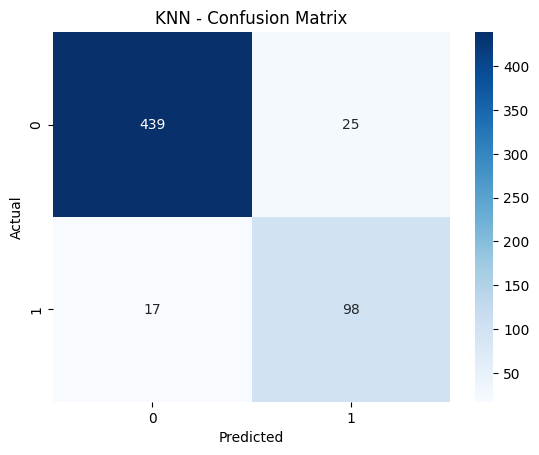


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       464
           1       0.80      0.85      0.82       115

    accuracy                           0.93       579
   macro avg       0.88      0.90      0.89       579
weighted avg       0.93      0.93      0.93       579

=== Evaluation for AdaBoost - Count Vectorization ===
Accuracy: 0.9930915371329879
Precision: 0.9930915371329879
Recall: 0.9930915371329879
F1-Score: 0.9930915371329879

Confusion Matrix:


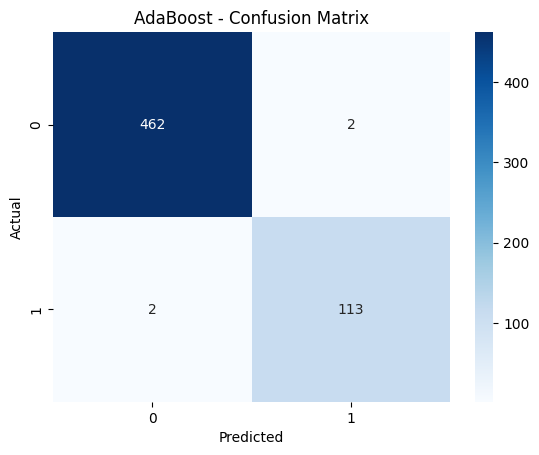


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       464
           1       0.98      0.98      0.98       115

    accuracy                           0.99       579
   macro avg       0.99      0.99      0.99       579
weighted avg       0.99      0.99      0.99       579

=== Evaluation for Decision Tree - Count Vectorization ===
Accuracy: 0.9775474956822107
Precision: 0.977842576631354
Recall: 0.9775474956822107
F1-Score: 0.9776556302349626

Confusion Matrix:


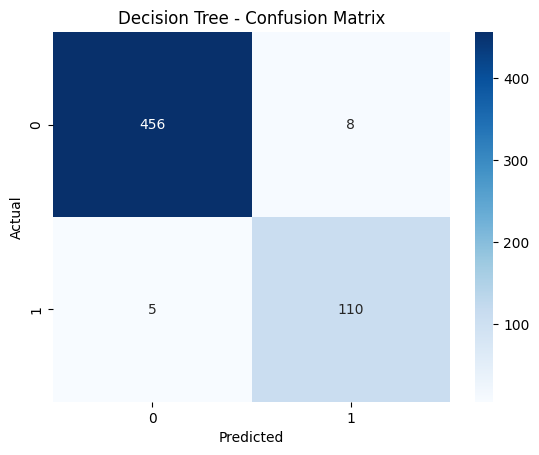


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       464
           1       0.93      0.96      0.94       115

    accuracy                           0.98       579
   macro avg       0.96      0.97      0.97       579
weighted avg       0.98      0.98      0.98       579



In [61]:
# Evaluate KNN
evaluate_model(y_test_countknn, y_pred_knn_count, "KNN", "Count Vectorization")

# Evaluate AdaBoost
evaluate_model(y_test_countab, y_pred_ada_count, "AdaBoost", "Count Vectorization")

# Evaluate Decision Tree
evaluate_model(y_test_countdt, y_pred_tree_count, "Decision Tree", "Count Vectorization")

## TF-IDF Vectorization

=== Evaluation for KNN - TF-IDF Vectorization ===
Accuracy: 0.9810017271157168
Precision: 0.9809482617904726
Recall: 0.9810017271157168
F1-Score: 0.9809704712905138

Confusion Matrix:


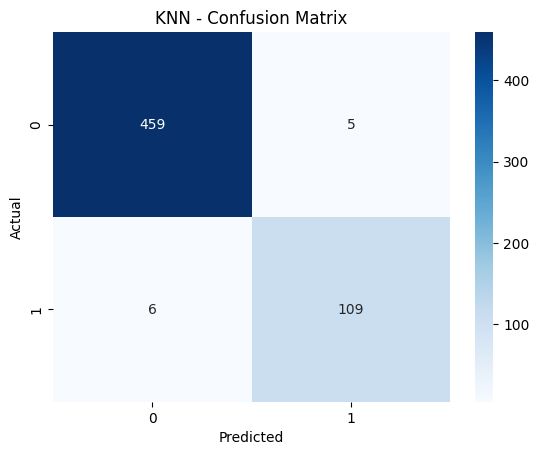


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       464
           1       0.96      0.95      0.95       115

    accuracy                           0.98       579
   macro avg       0.97      0.97      0.97       579
weighted avg       0.98      0.98      0.98       579

=== Evaluation for AdaBoost - TF-IDF Vectorization ===
Accuracy: 0.9896373056994818
Precision: 0.9896488756592384
Recall: 0.9896373056994818
F1-Score: 0.9895678379816026

Confusion Matrix:


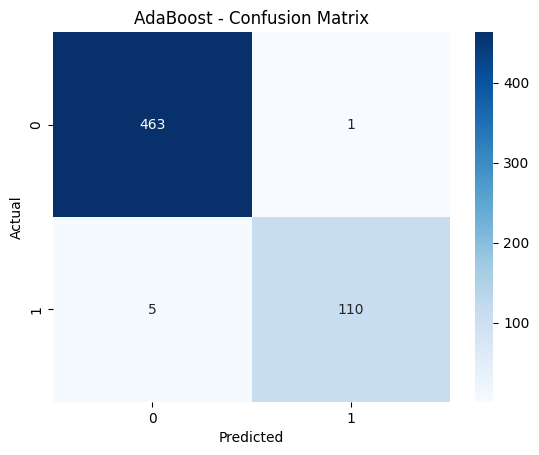


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       464
           1       0.99      0.96      0.97       115

    accuracy                           0.99       579
   macro avg       0.99      0.98      0.98       579
weighted avg       0.99      0.99      0.99       579

=== Evaluation for Decision Tree - TF-IDF Vectorization ===
Accuracy: 0.9671848013816926
Precision: 0.9669367497362304
Recall: 0.9671848013816926
F1-Score: 0.9670208317514766

Confusion Matrix:


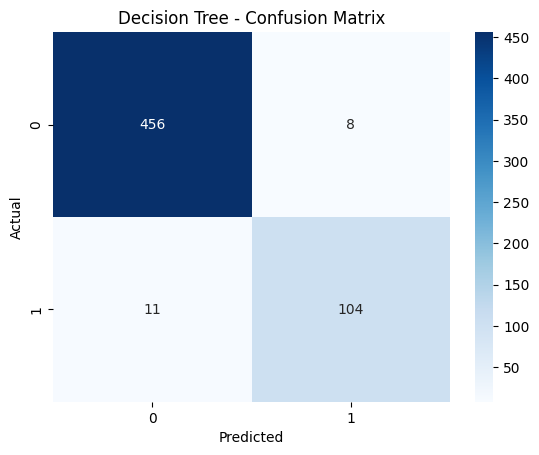


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       464
           1       0.93      0.90      0.92       115

    accuracy                           0.97       579
   macro avg       0.95      0.94      0.95       579
weighted avg       0.97      0.97      0.97       579



In [62]:
# Evaluate KNN
evaluate_model(y_test_tfidfknn, y_pred_knn_tfidf, "KNN", "TF-IDF Vectorization")

# Evaluate AdaBoost
evaluate_model(y_test_tfidfab, y_pred_ada_tfidf, "AdaBoost", "TF-IDF Vectorization")

# Evaluate Decision Tree
evaluate_model(y_test_tfidfdt, y_pred_tree_tfidf, "Decision Tree", "TF-IDF Vectorization")